<a href="https://colab.research.google.com/github/alexandertaoadams/AlexanderAdamsMastersThesis/blob/main/NB_RacketSports_Sparse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Time Series Classification: RacketSports**

https://www.timeseriesclassification.com/description.php?Dataset=RacketSports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gpjax
!pip install sktime

In [ ]:
# import os
import os

# jax libraries
import numpy as np
import jax
import jax.numpy as jnp

# gpjax libraries
import gpjax as gpx

# core libraries
from flax import nnx
import optax as ox

# data manipulation and visualisation libraries
import pandas as pd
from sktime.datasets import load_from_tsfile
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
!git clone https://github.com/alexandertaoadams/AlexanderAdamsMastersThesis.git

import sys
sys.path.insert(0, '/content/AlexanderAdamsMastersThesis')
import AlexanderAdamsMastersThesis.src as src

from src.kernels import SignatureKernel
from src.inducing_variables import initial_inducing_variables
from src.utils import display_parameters, display_results, normalise

from src.models import CollapsedBernoulliVariationalGaussian
from src.objectives import collapsed_elbo_bernoulli

### **Data Loading and Preprocessing**

In [ ]:
file_path_train = "/content/drive/MyDrive/DATA_RacketSports/RacketSports_TRAIN.ts"
file_path_test = "/content/drive/MyDrive/DATA_RacketSports/RacketSports_TEST.ts"

train_data, train_labels = load_from_tsfile(file_path_train)
test_data, test_labels = load_from_tsfile(file_path_test)

train_data_2 = jnp.array((np.stack([np.stack(row) for row in train_data.to_numpy()])))
train_labels_2 = jnp.array([
    0 if str(i).lower() in ["badminton_smash", "badminton_clear"] else 1
    for i in train_labels])
xtrain, train_mean, train_std = normalise(train_data_2)
ytrain = train_labels_2

test_data_2 = jnp.array((np.stack([np.stack(row) for row in test_data.to_numpy()])))
test_labels_2 = jnp.array([
    0 if str(i).lower() in ["badminton_smash", "badminton_clear"] else 1
    for i in test_labels])
xtest = (test_data_2 - train_mean) / (train_std)
ytest = test_labels_2

### **Model Training**

In [ ]:
# Initialising model
q_kernel = SignatureKernel(6, 30, 4)
q_mean_function = gpx.mean_functions.Constant(constant=jnp.array([0.5]))
q_prior = gpx.gps.Prior(mean_function=q_mean_function, kernel=q_kernel)
q_likelihood = gpx.likelihoods.Bernoulli(num_datapoints=xtrain.shape[0], integrator=gpx.integrators.GHQuadratureIntegrator(num_points=xtrain.shape[0]))
q_posterior = q_likelihood * q_prior

# Create dataset, initialise inducing variables
D = gpx.dataset.Dataset(jnp.reshape(xtrain, (xtrain.shape[0], -1)), jnp.expand_dims(ytrain, axis=1))
Z = initial_inducing_variables(xtrain, ytrain, 32)

# Model
q_collapsed = CollapsedBernoulliVariationalGaussian(
    posterior=q_posterior,
    inducing_inputs=Z
)

In [ ]:
# Training
collapsed_optimised_model, history = gpx.fit(
    model=q_collapsed,
    objective= lambda model, data: -collapsed_elbo_bernoulli(model, data),
    train_data=D,
    optim=ox.adam(learning_rate=1e-3),
    trainable=Parameter,
    num_iters=2500,
    batch_size=151,
    verbose=True
)

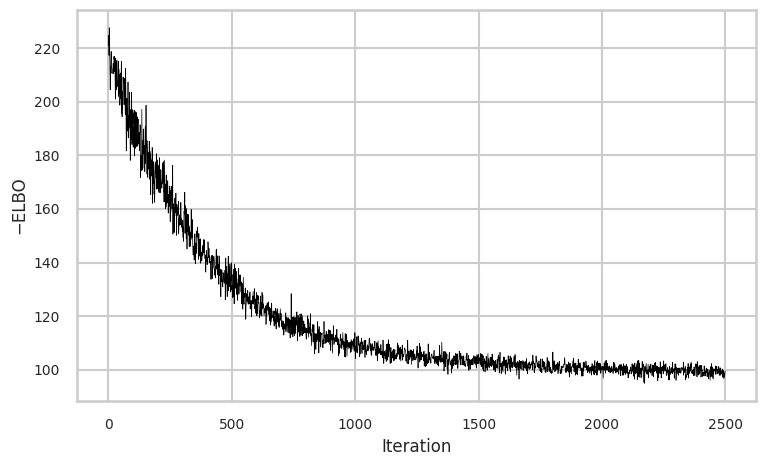

In [ ]:
# Plot training process
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(8, 5))
plt.plot(history, color="black", linewidth=0.5, label="Training ELBO")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("−ELBO", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# Display model hyperparameters
params = display_parameters(collapsed_optimised_model)
params

,Parameter,Count,Values
0,Lengthscales,6,"[4.225604, 4.477503, 4.451196, 4.30135, 4.2234..."
1,Amplitude,1,[0.47477454]
2,Weights,5,"[0.8080206, 0.2400226, 0.70569617, 0.41302925,..."


### **Model Evaluation**

In [ ]:
# Get predicted means
latent_dist = collapsed_optimised_model.predict(xtest, D)
predicted_dist = collapsed_optimised_model.posterior.likelihood(latent_dist)
predicted_mean_collapsed = predicted_dist.mean

# Get predicted class labels (0 or 1)
predicted_labels_collapsed = jnp.round(predicted_mean_collapsed)

# print("Predicted means:", predicted_mean_collapsed)
# print("Predicted labels:", predicted_labels_collapsed)
# print("True labels:", ytest)


In [ ]:
# Display results
results = display_results(predicted_labels_collapsed, ytest)
results

,Value
Metric,
Total samples,152.000
Negatives (0),83.000
Positives (1),69.000
MCC,0.737
F1 score,0.859
Precision,0.836
Recall,0.884
